Use and timing of threshold rebin method compared to standard PMap rebinning

In [22]:
%matplotlib inline

import time

import numpy as np
import matplotlib.pyplot as plt

from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.reco.pmaps_functions import           rebin_peak
from invisible_cities.reco.pmaps_functions import get_threshold_slices
from invisible_cities.reco.pmaps_functions import      get_even_slices
from invisible_cities.reco.pmaps_functions import          RebinMethod

plt.rcParams["figure.figsize"] = 10, 7.5

pmaps = load_pmaps('../IC/testNotebooks/pmaps_0000_6238_trg2_v0.9.9_20180727_krth1300.h5')


In [3]:
pmt_sum = pmaps[1].s2s[0].pmts.sum_over_sensors
## PMT sum threshold of 4000 pe and 9000 pe
threshold_1 = 4000
threshold_2 = 9000
%timeit -o get_even_slices(pmaps[1].s2s[0].times.shape[0], 2)
%timeit -o get_threshold_slices(pmt_sum, threshold_1)
%timeit -o get_threshold_slices(pmt_sum, threshold_2)

4.75 µs ± 206 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
70.5 µs ± 1.98 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
75.7 µs ± 3.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 75.7 µs ± 3.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [4]:
%timeit -o rebin_peak(pmaps[1].s2s[0], 2)
%timeit -o rebin_peak(pmaps[1].s2s[0], threshold_1, RebinMethod.threshold)
%timeit -o rebin_peak(pmaps[1].s2s[0], threshold_2, RebinMethod.threshold)

1.64 ms ± 8.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.81 ms ± 59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.51 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 1.51 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

How does the rebinning work

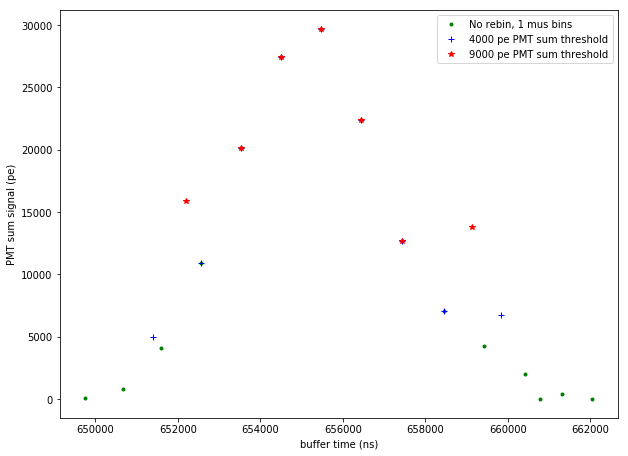

In [6]:
reb_pk_stand = rebin_peak(pmaps[1].s2s[0], 2)
reb_pk_threh1 = rebin_peak(pmaps[1].s2s[0], threshold_1, RebinMethod.threshold)
reb_pk_threh2 = rebin_peak(pmaps[1].s2s[0], threshold_2, RebinMethod.threshold)
plt.errorbar(pmaps[1].s2s[0].times, pmaps[1].s2s[0].pmts.sum_over_sensors, fmt='g.', label='No rebin, 1 mus bins')
plt.errorbar(reb_pk_threh1.times, reb_pk_threh1.pmts.sum_over_sensors, fmt='b+', label=str(threshold_1)+' pe PMT sum threshold')
plt.errorbar(reb_pk_threh2.times, reb_pk_threh2.pmts.sum_over_sensors, fmt='r*', label=str(threshold_2)+' pe PMT sum threshold')
plt.xlabel('buffer time (ns)')
plt.ylabel('PMT sum signal (pe)')
plt.legend()

And how does that translate to the tracking plane, both without rebin, 2 bin stride and threshold

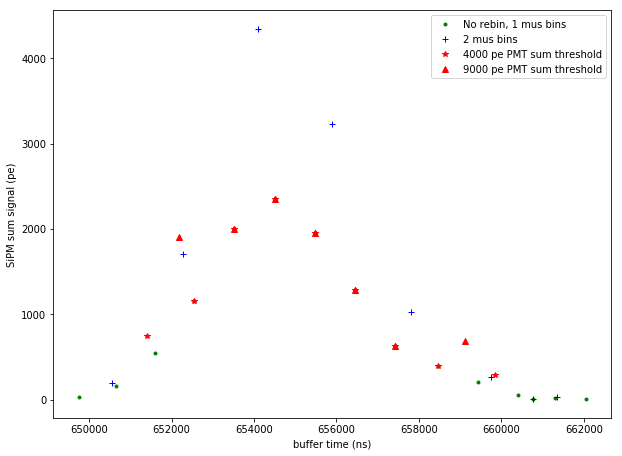

In [7]:
plt.errorbar(pmaps[1].s2s[0].times, pmaps[1].s2s[0].sipms.sum_over_sensors, fmt='g.', label='No rebin, 1 mus bins')
plt.errorbar(reb_pk_stand.times, reb_pk_stand.sipms.sum_over_sensors, fmt='b+', label='2 mus bins')
plt.errorbar(reb_pk_threh1.times, reb_pk_threh1.sipms.sum_over_sensors, fmt='r*', label=str(threshold_1)+' pe PMT sum threshold')
plt.errorbar(reb_pk_threh2.times, reb_pk_threh2.sipms.sum_over_sensors, fmt='r^', label=str(threshold_2)+' pe PMT sum threshold')
plt.xlabel('buffer time (ns)')
plt.ylabel('SiPM sum signal (pe)')
plt.legend()

Looking at the sipm with maximum charge for each slice

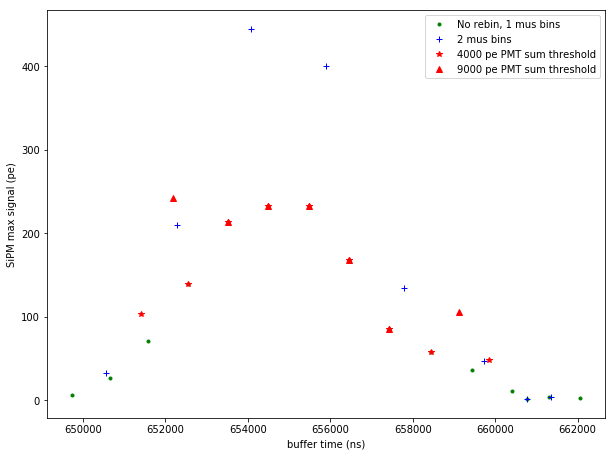

In [8]:
max_array_1mus  = pmaps[1].s2s[0].sipms.all_waveforms.max(axis=0)
max_array_2mus  = reb_pk_stand.sipms.all_waveforms.max(axis=0)
max_array_thre1 = reb_pk_threh1.sipms.all_waveforms.max(axis=0)
max_array_thre2 = reb_pk_threh2.sipms.all_waveforms.max(axis=0)
plt.errorbar(pmaps[1].s2s[0].times, max_array_1mus, fmt='g.', label='No rebin, 1 mus bins')
plt.errorbar(reb_pk_stand.times, max_array_2mus, fmt='b+', label='2 mus bins')
plt.errorbar(reb_pk_threh1.times, max_array_thre1, fmt='r*', label=str(threshold_1)+' pe PMT sum threshold')
plt.errorbar(reb_pk_threh2.times, max_array_thre2, fmt='r^', label=str(threshold_2)+' pe PMT sum threshold')
plt.xlabel('buffer time (ns)')
plt.ylabel('SiPM max signal (pe)')
plt.legend()

Event at 2 mus where some slices have a huge amount of charge there are some with a tiny amount. However, with the threshold method all slices have tracking plane information at levels for reliable reconstruction.

Total energy of strange event:  214470.19


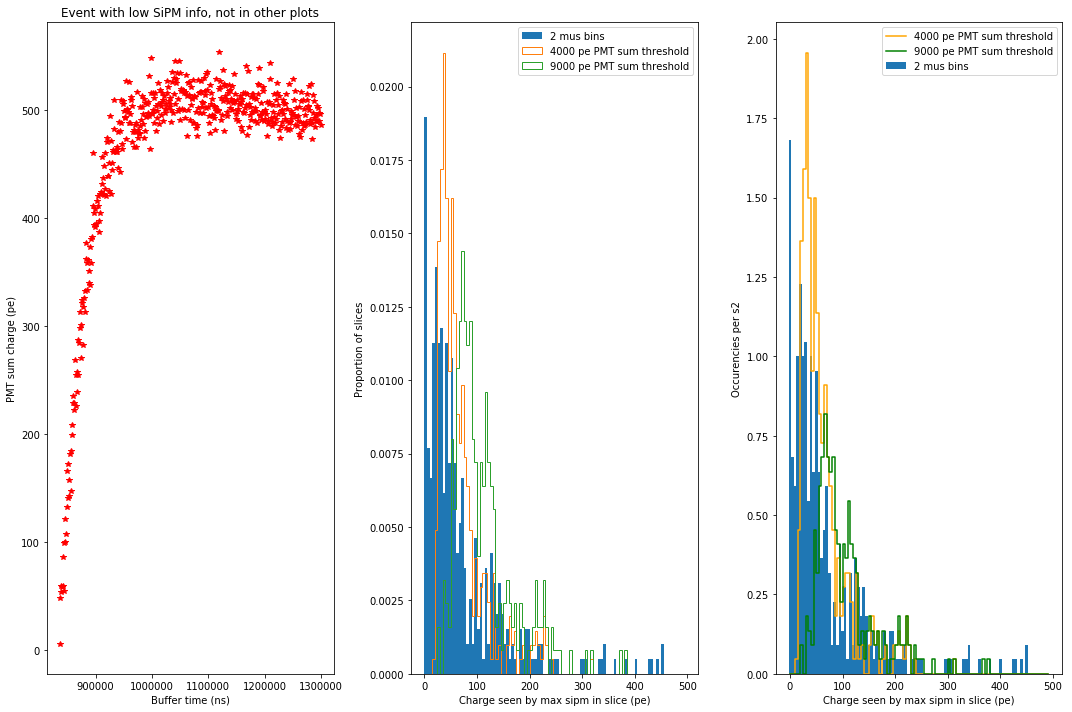

In [35]:
plt.rcParams["figure.figsize"] = 15, 10
maxes_stand  = []
maxes_threh1 = []
maxes_threh2 = []
n_s2s        = 0
for pmap in pmaps.values():
    for s2 in pmap.s2s:
        n_s2s += 1
        reb_stand  = rebin_peak(s2, 2)
        reb_threh1 = rebin_peak(s2, threshold_1, RebinMethod.threshold)
        if np.any(reb_threh1.sipms.all_waveforms.max(axis=0) < 5):
            print('Total energy of strange event: ', s2.total_energy)
            plt.subplot(1, 3, 1)
            plt.errorbar(s2.times, s2.pmts.sum_over_sensors, fmt='r*')
            plt.xlabel('Buffer time (ns)')
            plt.ylabel('PMT sum charge (pe)')
            plt.title('Event with low SiPM info, not in other plots')
            continue
        reb_threh2 = rebin_peak(s2, threshold_2, RebinMethod.threshold)
        maxes_stand .append( reb_stand.sipms.all_waveforms.max(axis=0))
        maxes_threh1.append(reb_threh1.sipms.all_waveforms.max(axis=0))
        maxes_threh2.append(reb_threh2.sipms.all_waveforms.max(axis=0))

binning = np.arange(0, 500, 5)
plt.subplot(1, 3, 2)
plt.hist( np.concatenate(maxes_stand), bins=binning, label='2 mus bins', density=True)
plt.hist(np.concatenate(maxes_threh1), bins=binning, label=str(threshold_1)+' pe PMT sum threshold', density=True, histtype='step')
plt.hist(np.concatenate(maxes_threh2), bins=binning, label=str(threshold_2)+' pe PMT sum threshold', density=True, histtype='step')
plt.xlabel('Charge seen by max sipm in slice (pe)')
plt.ylabel('Proportion of slices')
plt.legend()

plt.subplot(1, 3, 3)
hist_stand, bins_stand   = np.histogram( np.concatenate(maxes_stand), bins=binning)
hist_threh1, bins_threh1 = np.histogram(np.concatenate(maxes_threh1), bins=binning)
hist_threh2, bins_threh2 = np.histogram(np.concatenate(maxes_threh2), bins=binning)
wids_stand  = np.diff( bins_stand)
wids_threh1 = np.diff(bins_threh1)
wids_threh2 = np.diff(bins_threh2)
plt.bar( bins_stand[:-1],  hist_stand / n_s2s,  wids_stand, label='2 mus bins')
#plt.bar(bins_threh1[:-1], hist_threh1 / n_s2s, wids_threh1, label=str(threshold_1)+' pe PMT sum threshold', fill=False, edgecolor='r')
#plt.bar(bins_threh2[:-1], hist_threh2 / n_s2s, wids_threh2, label=str(threshold_2)+' pe PMT sum threshold', fill=False, edgecolor='g')
plt.plot(bins_threh1[:-1], hist_threh1 / n_s2s, label=str(threshold_1)+' pe PMT sum threshold', ls='steps', color='orange')
plt.plot(bins_threh2[:-1], hist_threh2 / n_s2s, label=str(threshold_2)+' pe PMT sum threshold', ls='steps', color='green')
plt.xlabel('Charge seen by max sipm in slice (pe)')
plt.ylabel('Occurencies per s2')
plt.legend()
plt.tight_layout()

Looking at all S2s in the file we find that the occurence of slicess with max sipm charge below 5 pe is vanishing for the threshold rebin but remains frequent for 2 mus rebinning